In [19]:
import os
import numpy as np
import json

import matplotlib.pyplot as plt

from pyddeeg import METRIC_NAME_TO_INDEX

ROOT = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/"
ELECTRODE_INDEXED = os.path.join(ROOT, "electrode_indexed")
DATASET_INDEXES = json.load(
    open(os.path.join(ELECTRODE_INDEXED, "dataset_index.json"), "r")
)

METRIC_NAME_TO_INDEX

{'RR': 0,
 'DET': 1,
 'L_max': 2,
 'L_mean': 3,
 'ENT': 4,
 'LAM': 5,
 'TT': 6,
 'V_max': 7,
 'V_mean': 8,
 'V_ENT': 9,
 'W_max': 10,
 'W_mean': 11,
 'W_ENT': 12,
 'CLEAR': 13,
 'PERM_ENT': 14}

In [68]:
import os
import numpy as np
import mne

from mne.channels import make_standard_montage
from pyddeeg import METRIC_NAME_TO_INDEX

# Example channel list (32-channel standard)
EEG_CHANNELS = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", 
    "FC6", "T7", "C3", "Cz", "C4", "T8", "TP9", "CP5", "CP1", "CP2", 
    "CP6", "TP10", "P7", "P3", "Pz", "P4", "P8", "PO9", "O1", "Oz", 
    "O2", "PO10"
]

def get_patient_evoked(window_size, 
                       direction, 
                       group, 
                       metric_name, 
                       patient_index, 
                       sfreq=1.0, 
                       tmin=0.0, 
                       montage_name="standard_1020"):
    """
    Extract patient data for a specific metric across all electrodes and 
    convert it to an MNE Evoked object.

    Parameters:
    -----------
    window_size (str): 
        Size of the window (e.g., 'window_50').
    direction (str): 
        Direction of stimulus ('up' or 'down').
    group (str): 
        Patient group ('CT' or 'DD').
    metric_name (str): 
        Name of the RQA metric.
    patient_index (int): 
        Index of the patient in the .npz file.
    sfreq (float, optional): 
        Sampling frequency in Hz, defaults to 1.0 (one value per window).
    tmin (float, optional):
        Start time of the data in seconds, defaults to 0.0.
    montage_name (str, optional):
        Name of the standard montage used, defaults to "standard_1020".

    Returns:
    --------
    mne.Evoked:
        MNE Evoked object containing the specified patient’s RQA data 
        for all channels across time windows.
    """
    # Validate metric
    if metric_name not in METRIC_NAME_TO_INDEX:
        raise ValueError(f"Invalid metric_name. Options: {list(METRIC_NAME_TO_INDEX.keys())}")
    
    metric_index = METRIC_NAME_TO_INDEX[metric_name]

    # Collect the data (channels x time_windows)
    electrode_data = []
    electrode_names = []

    # Assuming you have a global structure, e.g. DATASET_INDEXES, that maps
    #   (window_size, direction, electrode) -> file path
    if window_size not in DATASET_INDEXES:
        raise ValueError(f"Invalid window_size. Options: {list(DATASET_INDEXES.keys())}")
    
    if direction not in DATASET_INDEXES[window_size]:
        raise ValueError(f"Invalid direction. Options: {list(DATASET_INDEXES[window_size].keys())}")

    electrodes = list(DATASET_INDEXES[window_size][direction].keys())

    for electrode in electrodes:
        file_paths = DATASET_INDEXES[window_size][direction][electrode]
        file_path = None

        # Look for the correct file in the specified group
        for path in file_paths:
            filename = os.path.basename(path)
            if f"{electrode}_{group}_{direction.upper()}" in filename:
                file_path = path
                break
        
        # Skip if no file found
        if file_path is None:
            print(f"Warning: No data found for electrode {electrode} in group {group}")
            continue

        # Load the data
        try:
            npz_file = np.load(file_path)
            metrics_data = npz_file['metrics']

            # Check if patient index is valid
            if patient_index >= metrics_data.shape[0]:
                print(f"Warning: Patient index {patient_index} out of range for {electrode} in group {group}")
                continue

            # Extract data for the specified patient and metric
            data = metrics_data[patient_index, metric_index, :]

            # Append to main list
            electrode_data.append(data)
            electrode_names.append(electrode)

        except Exception as e:
            print(f"Error loading data for electrode {electrode}: {e}")

    if not electrode_data:
        raise ValueError("No valid data found for the specified parameters")

    # Convert list to (n_channels, n_times)
    data_tensor = np.array(electrode_data)

    # Create MNE Info
    ch_types = ['eeg'] * len(electrode_names)
    info = mne.create_info(ch_names=electrode_names, sfreq=sfreq, ch_types=ch_types)
    
    # Build an EvokedArray from the data
    evoked = mne.EvokedArray(data_tensor, info, tmin=tmin)

    # Set montage (electrode locations)
    montage = make_standard_montage(montage_name)
    evoked.set_montage(montage)
    
    return evoked


No projector specified for this dataset. Please consider the method self.add_proj.


matplotlib.figure.Figure

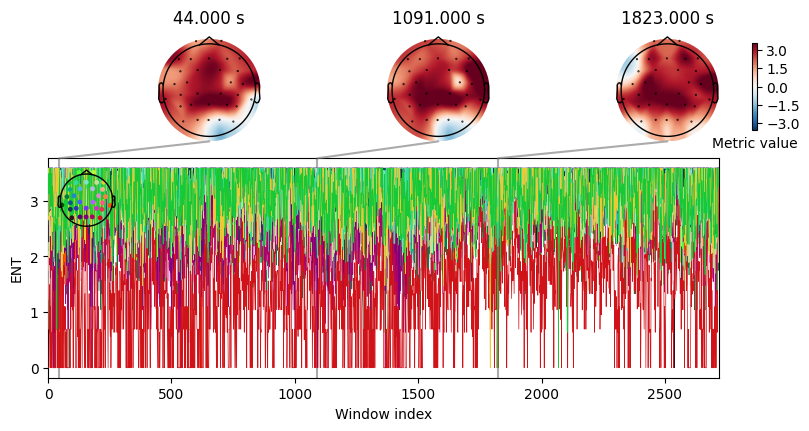

In [144]:
import mne

import os
import numpy as np
import mne

from mne.channels import make_standard_montage
from pyddeeg import METRIC_NAME_TO_INDEX

# Example channel list (32-channel standard)
EEG_CHANNELS = [
    "Fp1", "Fp2", "F7", "F3", "Fz", "F4", "F8", "FC5", "FC1", "FC2", 
    "FC6", "T7", "C3", "Cz", "C4", "T8", "TP9", "CP5", "CP1", "CP2", 
    "CP6", "TP10", "P7", "P3", "Pz", "P4", "P8", "PO9", "O1", "Oz", 
    "O2", "PO10"
]

def get_patient_evoked(window_size, 
                       direction, 
                       group, 
                       metric_name, 
                       patient_index, 
                       sfreq=1.0, 
                       tmin=0.0, 
                       montage_name="standard_1020"):
    """
    Extract patient data for a specific metric across all electrodes and 
    convert it to an MNE Evoked object.

    Parameters:
    -----------
    window_size (str): 
        Size of the window (e.g., 'window_50').
    direction (str): 
        Direction of stimulus ('up' or 'down').
    group (str): 
        Patient group ('CT' or 'DD').
    metric_name (str): 
        Name of the RQA metric.
    patient_index (int): 
        Index of the patient in the .npz file.
    sfreq (float, optional): 
        Sampling frequency in Hz, defaults to 1.0 (one value per window).
    tmin (float, optional):
        Start time of the data in seconds, defaults to 0.0.
    montage_name (str, optional):
        Name of the standard montage used, defaults to "standard_1020".

    Returns:
    --------
    mne.Evoked:
        MNE Evoked object containing the specified patient’s RQA data 
        for all channels across time windows.
    """
    # Validate metric
    if metric_name not in METRIC_NAME_TO_INDEX:
        raise ValueError(f"Invalid metric_name. Options: {list(METRIC_NAME_TO_INDEX.keys())}")
    
    metric_index = METRIC_NAME_TO_INDEX[metric_name]

    # Collect the data (channels x time_windows)
    electrode_data = []
    electrode_names = []

    # Assuming you have a global structure, e.g. DATASET_INDEXES, that maps
    #   (window_size, direction, electrode) -> file path
    if window_size not in DATASET_INDEXES:
        raise ValueError(f"Invalid window_size. Options: {list(DATASET_INDEXES.keys())}")
    
    if direction not in DATASET_INDEXES[window_size]:
        raise ValueError(f"Invalid direction. Options: {list(DATASET_INDEXES[window_size].keys())}")

    electrodes = list(DATASET_INDEXES[window_size][direction].keys())

    for electrode in electrodes:
        file_paths = DATASET_INDEXES[window_size][direction][electrode]
        file_path = None

        # Look for the correct file in the specified group
        for path in file_paths:
            filename = os.path.basename(path)
            if f"{electrode}_{group}_{direction.upper()}" in filename:
                file_path = path
                break
        
        # Skip if no file found
        if file_path is None:
            print(f"Warning: No data found for electrode {electrode} in group {group}")
            continue

        # Load the data
        try:
            npz_file = np.load(file_path)
            metrics_data = npz_file['metrics']

            # Check if patient index is valid
            if patient_index >= metrics_data.shape[0]:
                print(f"Warning: Patient index {patient_index} out of range for {electrode} in group {group}")
                continue

            # Extract data for the specified patient and metric
            data = metrics_data[patient_index, metric_index, :]

            # Append to main list
            electrode_data.append(data)
            electrode_names.append(electrode)

        except Exception as e:
            print(f"Error loading data for electrode {electrode}: {e}")

    if not electrode_data:
        raise ValueError("No valid data found for the specified parameters")

    # Convert list to (n_channels, n_times)
    data_tensor = np.array(electrode_data)

    # Create MNE Info
    ch_types = ['eeg'] * len(electrode_names)
    info = mne.create_info(ch_names=electrode_names, sfreq=sfreq, ch_types=ch_types)
    
    # Build an EvokedArray from the data
    evoked = mne.EvokedArray(data_tensor, info, tmin=tmin)

    # Set montage (electrode locations)
    montage = make_standard_montage(montage_name)
    evoked.set_montage(montage)
    
    return evoked

# Example: evoked is your Evoked object
metric_name = "ENT"

evoked = get_patient_evoked(window_size="window_50",
                            direction="up",
                            group="CT",
                            metric_name=metric_name,  
                            patient_index=0,
                            sfreq=1.0,
                            tmin=0.0,
                            montage_name="standard_1020")

ts_args = dict(
    spatial_colors=True,
    zorder='std',
    units=dict(eeg=metric_name),
    scalings=dict(eeg=1),
)

# Note: do NOT include "colorbar" in topomap_args
topomap_args = dict(
    outlines='head',
    contours=0
)

# Temporarily overwrite them
old_nave = evoked.nave
old_comment = evoked.comment

evoked.nave = None         # This prevents "Nave=1" from being appended
evoked.comment = None      # Also remove any default comment from the auto-title

fig = evoked.plot_joint(
    times="peaks",
    title=None,        # or some custom string
    picks="eeg",
    exclude="bads",
    show=False,
    ts_args=ts_args,
    topomap_args=topomap_args
)

# Restore them if needed
evoked.nave = old_nave
evoked.comment = old_comment


# Adjust axis labels after the figure is created

time_ax = fig.axes[-3]  # the main time-series axis
time_ax.set_xlabel("Window index")
cbar_ax = fig.axes[-1]
cbar_ax.set_xlabel("Metric value")
cbar_ax.yaxis.get_offset_text().set_visible(False)
last_topo_ax = fig.axes[-4]



type(fig)

No projector specified for this dataset. Please consider the method self.add_proj.
No projector specified for this dataset. Please consider the method self.add_proj.


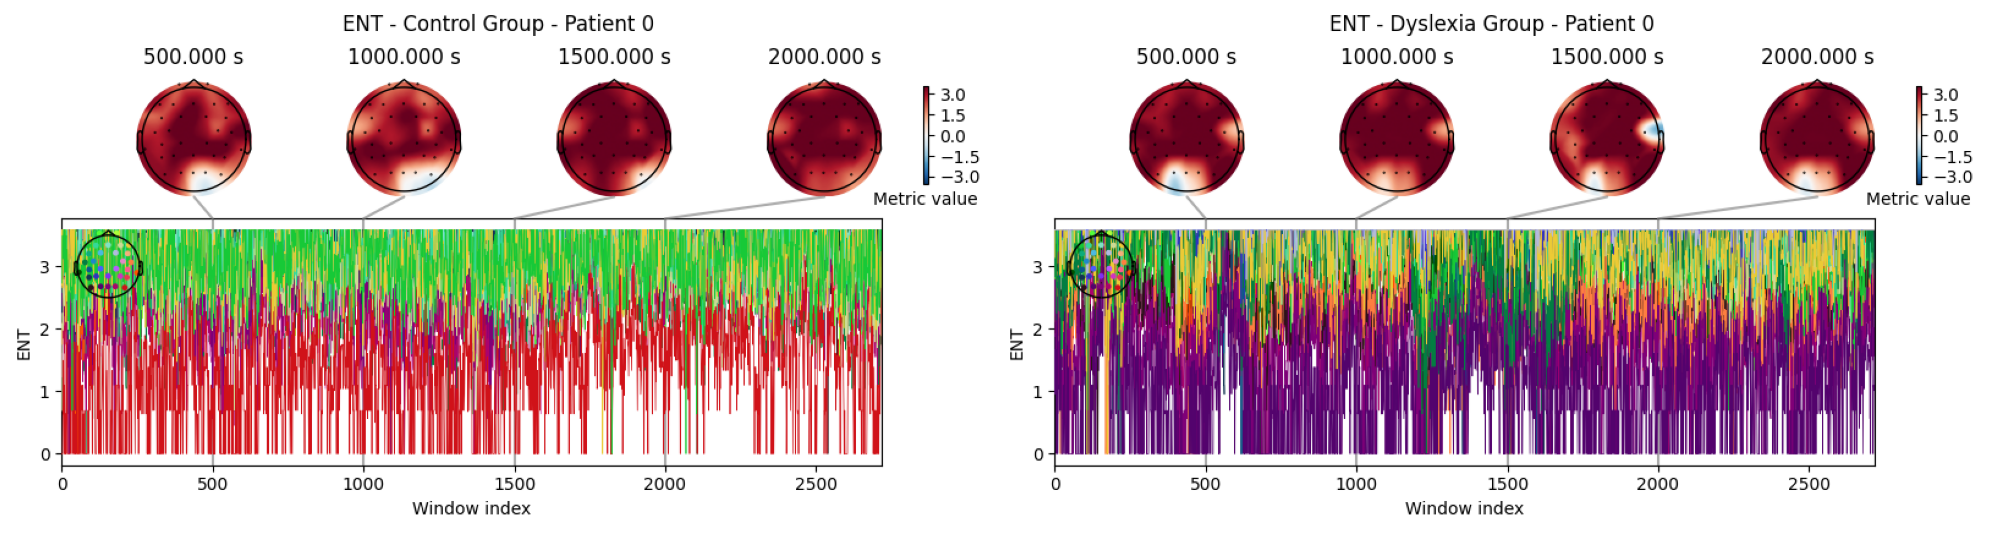

In [3]:
import sys
import os

# Add the project root to the path if needed
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

from pyddeeg.mne_utils import window_experiment_utils as mne_utils

# Load dataset indexes
ROOT = "/home/mario/Python/Datasets/EEG/timeseries/processed/rqa_windows/"
dataset_indexes = mne_utils.load_dataset_indexes(ROOT)

import matplotlib.pyplot as plt

# Create side-by-side comparison
fig = mne_utils.create_group_comparison_plot(
    patient_index=0,
    window_size="window_50",
    direction="up",
    metric_name="ENT",
    dataset_indexes=dataset_indexes,
    show=True,
    times = [500, 1000, 1500, 2000],
)

fig.savefig("comparison_plot.svg", dpi=300)